In [23]:
import torch
import torch.nn as nn
import tiktoken

In [26]:
tokenizer = tiktoken.get_encoding('gpt2')
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch,dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [3]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
out = layer(batch_example)
print("batch examole: ",batch_example)
print("output: ",out)

batch examole:  tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
output:  tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [4]:
#get the mean varience
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1,keepdim=True)
print("Mean:\n",mean)
print("Varience:\n",var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Varience:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [5]:
#normalizing the output layer
out_norm = (out-mean)/torch.sqrt(var)
mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
print("normalized layer:\n",out_norm)
print("mean:\n",mean)
print("varience:\n",var)

normalized layer:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
varience:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# Layer normalization class

In [6]:
import torch.nn as nn
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x = (x - mean)/torch.sqrt(var+self.eps)
        return self.scale*norm_x + self.shift

In [7]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1,keepdim=True)
var = out_ln.var(dim=-1,unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# Feed forward with GELU activation

In [8]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,x):
        return 0.5 * x * (1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x,3))
        ))

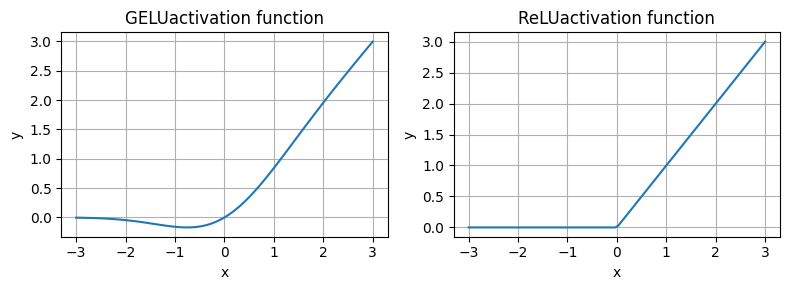

In [9]:
import matplotlib.pyplot as plt
gelu,relu = GELU(),nn.ReLU()

x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x),relu(x)
plt.figure(figsize=(8,3))
for i,(y,label) in enumerate(zip([y_gelu,y_relu],["GELU","ReLU"]),1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label}activation function")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),GELU(),
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
        )
        
    def forward(self,x):
        return self.layers(x)

In [11]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [12]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


# Nueral network with shortcut connections

In [13]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self,layer_sizes,use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),GELU()),
        ])
        
    def forward(self,x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
            return x

In [14]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes,use_shortcut = False
)

In [15]:
 layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])
 torch.manual_seed(123)                           
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
 )

In [6]:
def print_gradients(model,x):
    output = model(x)
    target = torch.tensor([[0.]])
    
    loss = nn.MSELoss()
    loss = loss(output,target)
    
    loss.backward()
    
    for name,param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [7]:
print_gradients(model_without_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.03372581675648689


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


AttributeError: 'NoneType' object has no attribute 'abs'

# Connecting attention and linear layers in a transformer block

In [16]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0),"d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.w_query = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.w_key = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.w_value = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.out_proj = nn.Linear(d_out,d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))
        
    def forward(self,x):
        b,num_tokens,d_in = x.shape
        keys = self.w_key(x)
        queries = self.w_query(x)
        values = self.w_value(x)
            
        keys = keys.view(b,num_tokens,self.num_heads,self.head_dim)
        values = values.view(b,num_tokens,self.num_heads,self.head_dim)
        queries = queries.view(b,num_tokens,self.num_heads,self.head_dim)
            
        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)
        
        attn_scores = queries @ keys.transpose(2, 3)  
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]    
        attn_scores.masked_fill_(mask_bool,-torch.inf)
        attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ values).transpose(1,2)
        context_vec = context_vec.contiguous().view(b,num_tokens,self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec 
            
            
            

In [20]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            num_heads = cfg['n_heads'],
            dropout = cfg['drop_rate'],
            qkv_bias = cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])
        
    def forward(self,x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
            
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [19]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape: ",x.shape)
print("Output shape: ",output.shape)

Input shape:  torch.Size([2, 4, 768])
Output shape:  torch.Size([2, 4, 768])


In [30]:
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
            )
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'],cfg['vocab_size'],bias=False
        )
        
    def forward(self,in_idx):
        batch_size,seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
        torch.arange(seq_len,device=in_idx.device)
            )
        x = tok_embeds+pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [31]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n",batch)
print("\nOutput shape:",out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [32]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [33]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
 )
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
 )

Number of trainable parameters considering weight tying: 124,412,160


In [34]:
total_size_bytes = total_params * 4      
total_size_mb = total_size_bytes / (1024 * 1024)    
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [37]:
def generate_text_simple(model,idx,max_new_tokens,context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
            
        logits = logits[:,-1,:]
        probas = torch.softmax(logits,dim=-1)
        idx_next = torch.argmax(probas,dim=-1,keepdim=True)
        idx = torch.cat((idx,idx_next),dim=-1)
        
    return idx

In [35]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:",encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:",encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [38]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M["context_length"]
)
print("Output:",out)
print("Output length:",len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [40]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
